frame, chirp_loop, chirp =  2  ,  18  ,  6 



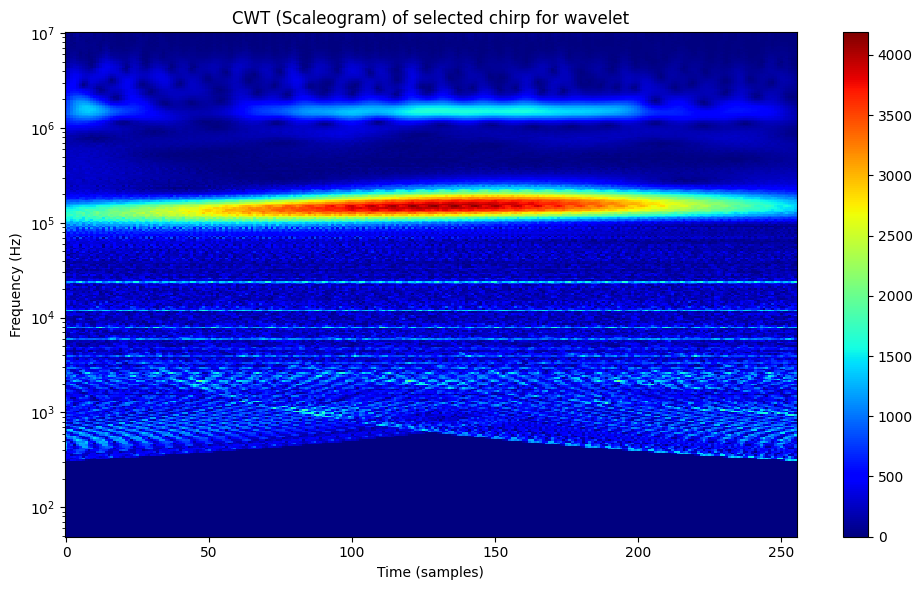

frame, chirp_loop, chirp =  3  ,  18  ,  6 



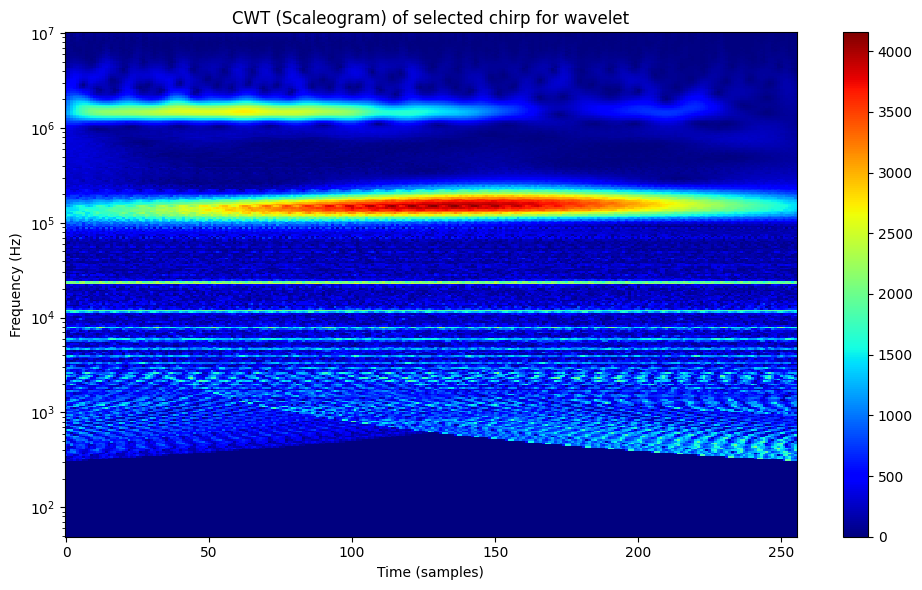

In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pywt
from scipy.signal import butter, filtfilt
import os  # To handle file paths

# # Define the save directory and base filename
# save_directory = r'G:\FYP\Scaleograms\Ground data UAV + F185 Scalograms\normal envi\fi'
# base_filename = 'normal env'

# # Ensure the save directory exists
# os.makedirs(save_directory, exist_ok=True)


for frame_index  in range(1,3,1):
    for chirp_loop_index  in range(17,18,1):
        for chirp_index in range(5,6,1):
            # Define file path and parameters
            fileFullPath = r'D:\Drone-Swarm-Detection-with-AWR2243\Our data\Radar_Data\Phantom4_3GHz\master_0000_data.bin';
            frameIdx = frame_index# Index of the frame to read
            numSamplePerChirp = 256  # Number of samples per chirp
            numChirpPerLoop = 12  # Number of chirps per loop
            numLoops = 64 # Number of loops per frame
            numRXPerDevice = 4  # Number of receiving channels per device
            numDevices = 4  # Number of devices in the cascade (if needed)

            # Create the filter for zero Doppler clutter removal
            cutoff_freq = 10  # Set cutoff frequency for the high-pass filter (Hz)
            sampling_freq = 1000  # Sampling frequency (example value, should match your data)
            def butter_highpass(cutoff, fs, order=6):
                """Design a Butterworth high-pass filter."""
                nyquist = 0.5 * fs
                normal_cutoff = cutoff / nyquist
                b, a = butter(order, normal_cutoff, btype='high', analog=False)
                return b, a
            b, a = butter_highpass(cutoff_freq, sampling_freq)

            # Function to read binary radar data
            def readBinFile(fileFullPath, frameIdx, numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice):
                Expected_Num_SamplesPerFrame = numSamplePerChirp * numChirpPerLoop * numLoops * numRXPerDevice * 2
                with open(fileFullPath, 'rb') as fp:
                    # Move to the desired frame in the file
                    fp.seek((frameIdx - 1) * Expected_Num_SamplesPerFrame * 2)
                    adcData1 = np.fromfile(fp, dtype=np.uint16, count=Expected_Num_SamplesPerFrame)

                # Convert the 16-bit data to signed integers
                neg = (adcData1 >> 15) == 1  # Check the sign bit
                adcData1 = adcData1.astype(np.int32)
                adcData1[neg] -= 2**16

                # Combine the I and Q channels into complex values
                adcData1 = adcData1[0::2] + 1j * adcData1[1::2]

                # Reshape and permute the data
                adcData1Complex = np.reshape(adcData1, (numRXPerDevice, numSamplePerChirp, numChirpPerLoop, numLoops), order='F')
                adcData1Complex = np.transpose(adcData1Complex, (1, 3, 0, 2))  # Permute dimensions
                return adcData1Complex

            # Read radar data
            adcDataComplex = readBinFile(fileFullPath, frameIdx, numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice)

            # Select antenna index and extract chirp ADC matrix
            antennaIdx = 3 # Indexing starts from 0 in Python
            chirp_ADC_matrix = adcDataComplex[:, :, antennaIdx, :]

            specific_transmitter_data = chirp_ADC_matrix[:, chirp_loop_index, chirp_index].T
            if filter and b is not None and a is not None:
                specific_transmitter_data = filtfilt(b,a,  specific_transmitter_data , axis=0)

            # Extract chirp_index chirp of the chirp_loop_index loop
            Aimed_chirp_for_wavelet = specific_transmitter_data.T
            # print("chirp_ADC_matrix shape" ,chirp_ADC_matrix.shape)
            # print("\n")
            print("frame, chirp_loop, chirp = ",frame_index+1, " , ", chirp_loop_index+1, " , " , chirp_index+1,"\n")

            # perform CWT
            wavelet = "cmor1.5-1.0"
            # logarithmic scale for scales, as suggested by Torrence & Compo:
            widths = np.geomspace(1, 200000, num=300)
            time_sampled = np.arange(256)
            # Apply CWT on the sampled chirp signal
            cwtmatr, freqs_new = pywt.cwt(Aimed_chirp_for_wavelet, widths, wavelet, sampling_period=1/1e7 )
            # Take absolute value of complex result
            cwtmatr = np.abs(cwtmatr)

            # print("Frequency values (Hz):")
            # print(freqs_new)
            # print("\n")

            # Plot the scaleogram (CWT result)
            plt.figure(figsize=(10, 6))
            pcm = plt.pcolormesh(time_sampled, freqs_new, cwtmatr, shading='auto', cmap='jet')
            plt.yscale("log")
            # # Set frequency axis limits to 0 Hz to 800 Hz
            # plt.ylim(55, 555)  # Limiting y-axis (frequency) from 0 to 800 Hz
            plt.xlabel("Time (samples)")
            plt.ylabel("Frequency (Hz)")
            plt.title(f"CWT (Scaleogram) of selected chirp for wavelet")
            plt.colorbar(pcm)
            plt.tight_layout()

            # # Save the figure
            # save_path = os.path.join(save_directory, f'{base_filename}_frame_{frame_index+1}_chirp-loop_{chirp_loop_index+1}_chirp_{chirp_index+1}.png')
            # plt.savefig(save_path)

            plt.show()
            # plt.close()  # Close the figure to avoid displaying it repeatedly